## Regression Model for Ames Iowa Housing Prices Using Python Take 2
### David Lowe
### June 24, 2019

Template Credit: Adapted from a template made available by Dr. Jason Brownlee of Machine Learning Mastery. [https://machinelearningmastery.com/]

SUMMARY: The purpose of this project is to construct a prediction model using various machine learning algorithms and to document the end-to-end steps using a template. The Ames Iowa Housing Prices dataset is a regression situation where we are trying to predict the value of a continuous variable.

INTRODUCTION: Many factors can influence a home's purchase price. This Ames Housing dataset contains 79 explanatory variables describing every aspect of residential homes in Ames, Iowa. The goal is to predict the final price of each home.

In iteration Take1, we established the baseline mean squared error for further takes of modeling.

In this iteration, we plan to convert some of the categorical variables from nominal to ordinal and observe the effects of the change.

ANALYSIS: The baseline performance of the machine learning algorithms achieved an average RMSE of 31,172. Two algorithms (Ridge Regression and Gradient Boosting) achieved the top RMSE metrics after the first round of modeling. After a series of tuning trials, Gradient Boosting turned in the best overall result and achieved an RMSE metric of 24,165. By using the optimized parameters, the Gradient Boosting algorithm processed the test dataset with an RMSE of 21,067, which was even better than the prediction from the training data.

From iteration Take2, Gradient Boosting achieved an RMSE metric of 23,612 with the training dataset and processed the test dataset with an RMSE of 21,130. Converting the nominal variables to ordinal did not have a material impact on the prediction accuracy in either direction.

CONCLUSION: For this iteration, the Gradient Boosting algorithm achieved the best overall results using the training and testing datasets. For this dataset, Gradient Boosting should be considered for further modeling.

Dataset Used: Kaggle Competition - House Prices: Advanced Regression Techniques

Dataset ML Model: Regression with numerical and categorical attributes

Dataset Reference: https://ww2.amstat.org/publications/jse/v19n3/decock.pdf

One potential source of performance benchmarks: https://www.kaggle.com/c/house-prices-advanced-regression-techniques

The project aims to touch on the following areas:

* Document a predictive modeling problem end-to-end.
* Explore data cleaning and transformation options
* Explore non-ensemble and ensemble algorithms for baseline model performance
* Explore algorithm tuning techniques for improving model performance

Any predictive modeling machine learning project genrally can be broken down into about six major tasks:

1. Prepare Problem
2. Summarize Data
3. Prepare Data
4. Model and Evaluate Algorithms
5. Improve Accuracy or Results
6. Finalize Model and Present Results

## Section 1 - Prepare Problem

### 1.a) Load ibraries

In [1]:
import math
import numpy as np
import pandas as pd
import os
import sys
import shutil
import urllib.request
import zipfile
import warnings
import smtplib
from datetime import datetime
from email.message import EmailMessage
from matplotlib import pyplot
from pandas import read_csv
from pandas import get_dummies
from pandas.plotting import scatter_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.pipeline import Pipeline
from sklearn.externals.joblib import dump
from sklearn.externals.joblib import load
from sklearn.feature_selection import RFE
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN
from imblearn.combine import SMOTETomek

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor

# Create one random seed number for reproducible results
seedNum = 888

### 1.b) Set up the email notification function

In [2]:
def email_notify(msg_text):
    sender = os.environ.get('MAIL_SENDER')
    receiver = os.environ.get('MAIL_RECEIVER')
    gateway = os.environ.get('SMTP_GATEWAY')
    smtpuser = os.environ.get('SMTP_USERNAME')
    password = os.environ.get('SMTP_PASSWORD')
    if sender==None or receiver==None or gateway==None or smtpuser==None or password==None:
        sys.exit("Incomplete email setup info. Script Processing Aborted!!!")
    msg = EmailMessage()
    msg.set_content(msg_text)
    msg['Subject'] = 'Notification from Python Regression Modeling Script'
    msg['From'] = sender
    msg['To'] = receiver
    server = smtplib.SMTP(gateway, 587)
    server.starttls()
    server.login(smtpuser, password)
    server.send_message(msg)
    server.quit()

In [3]:
# Set up the flag to send status emails (setting True will send!)
notifyStatus = False

In [4]:
if (notifyStatus): email_notify("Library and Data Loading has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 1.c) Load dataset

In [5]:
startTimeScript = datetime.now()

dataset_path = 'https://www.kaggle.com/c/house-prices-advanced-regression-techniques/download/train.csv'
dest_file = os.path.basename(dataset_path)
if (os.path.isfile(dest_file) == False) :
    print('Downloading ' + dataset_path + ' as ' + dest_file)
    with urllib.request.urlopen(dataset_path) as in_resp, open(dest_file, 'wb') as out_file:
        shutil.copyfileobj(in_resp, out_file)
    print(dest_file + 'downloaded!')
#     print('Unpacking ' + dest_file)
#     with zipfile.ZipFile(dest_file, 'r') as zip_ref:
#         zip_ref.extractall('.')
#     print(dest_file + 'unpacked!')

inputFile = dest_file
xy_original_df = read_csv(inputFile, sep=',', index_col=0)

In [6]:
# Take a peek at the dataframe after the import
xy_original_df.head(10)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
6,50,RL,85.0,14115,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,MnPrv,Shed,700,10,2009,WD,Normal,143000
7,20,RL,75.0,10084,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,307000
8,60,RL,NaN,10382,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,Shed,350,11,2009,WD,Normal,200000
9,50,RM,51.0,6120,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,4,2008,WD,Abnorml,129900


In [7]:
xy_original_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1460 entries, 1 to 1460
Data columns (total 80 columns):
MSSubClass       1460 non-null int64
MSZoning         1460 non-null object
LotFrontage      1201 non-null float64
LotArea          1460 non-null int64
Street           1460 non-null object
Alley            91 non-null object
LotShape         1460 non-null object
LandContour      1460 non-null object
Utilities        1460 non-null object
LotConfig        1460 non-null object
LandSlope        1460 non-null object
Neighborhood     1460 non-null object
Condition1       1460 non-null object
Condition2       1460 non-null object
BldgType         1460 non-null object
HouseStyle       1460 non-null object
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
RoofStyle        1460 non-null object
RoofMatl         1460 non-null object
Exterior1st      1460 non-null object
Exterior2nd      1460 non-

In [8]:
print('Number of NaN in the dataframe columns:\n', xy_original_df.isnull().sum())
print('Total number of NaN in the dataframe: ', xy_original_df.isnull().sum().sum())

Number of NaN in the dataframe columns:
 MSSubClass          0
MSZoning            0
LotFrontage       259
LotArea             0
Street              0
Alley            1369
LotShape            0
LandContour         0
Utilities           0
LotConfig           0
LandSlope           0
Neighborhood        0
Condition1          0
Condition2          0
BldgType            0
HouseStyle          0
OverallQual         0
OverallCond         0
YearBuilt           0
YearRemodAdd        0
RoofStyle           0
RoofMatl            0
Exterior1st         0
Exterior2nd         0
MasVnrType          8
MasVnrArea          8
ExterQual           0
ExterCond           0
Foundation          0
BsmtQual           37
                 ... 
BedroomAbvGr        0
KitchenAbvGr        0
KitchenQual         0
TotRmsAbvGrd        0
Functional          0
Fireplaces          0
FireplaceQu       690
GarageType         81
GarageYrBlt        81
GarageFinish       81
GarageCars          0
GarageArea          0
GarageQual   

### 1.d) Data CLeaning

In [9]:
# Dropping rows as recommended by the original report
xy_original_df.query('GrLivArea < 4000', inplace=True)

# Impute the missing values as necessary
xy_original_df['LotFrontage'].fillna(0, inplace=True)
xy_original_df['Alley'].fillna('NoAlley', inplace=True)
xy_original_df.Alley = xy_original_df.Alley.astype('category')
xy_original_df['MasVnrType'].fillna('NoMasonry', inplace=True)
xy_original_df.MasVnrType = xy_original_df.MasVnrType.astype('category')
xy_original_df['MasVnrArea'].fillna(0, inplace=True)
xy_original_df['Electrical'].fillna('Unknown', inplace=True)
xy_original_df.Electrical = xy_original_df.Electrical.astype('category')
xy_original_df['GarageType'].fillna('NoGarage', inplace=True)
xy_original_df.GarageType = xy_original_df.GarageType.astype('category')
xy_original_df['GarageYrBlt'].fillna(value=xy_original_df['GarageYrBlt'].min(), inplace=True)
xy_original_df['Fence'].fillna('NoFence', inplace=True)
xy_original_df.Fence = xy_original_df.Fence.astype('category')
xy_original_df['MiscFeature'].fillna('NoMiscFeature', inplace=True)
xy_original_df.MiscFeature = xy_original_df.MiscFeature.astype('category')

# Convert features with Y/N levels into category features
xy_original_df.MSSubClass = xy_original_df.MSSubClass.astype('category')
xy_original_df.MSZoning = xy_original_df.MSZoning.astype('category')
xy_original_df.Street = xy_original_df.Street.astype('category')
xy_original_df.LotShape = xy_original_df.LotShape.astype('category')
xy_original_df.LandContour = xy_original_df.LandContour.astype('category')
xy_original_df.Utilities = xy_original_df.Utilities.astype('category')
xy_original_df.LotConfig = xy_original_df.LotConfig.astype('category')
xy_original_df.LandSlope = xy_original_df.LandSlope.astype('category')
xy_original_df.Neighborhood = xy_original_df.Neighborhood.astype('category')
xy_original_df.Condition1 = xy_original_df.Condition1.astype('category')
xy_original_df.Condition2 = xy_original_df.Condition2.astype('category')
xy_original_df.BldgType = xy_original_df.BldgType.astype('category')
xy_original_df.HouseStyle = xy_original_df.HouseStyle.astype('category')
xy_original_df.RoofStyle = xy_original_df.RoofStyle.astype('category')
xy_original_df.RoofMatl = xy_original_df.RoofMatl.astype('category')
xy_original_df.Exterior1st = xy_original_df.Exterior1st.astype('category')
xy_original_df.Exterior2nd = xy_original_df.Exterior2nd.astype('category')
xy_original_df.Foundation = xy_original_df.Foundation.astype('category')
xy_original_df.Heating = xy_original_df.Heating.astype('category')
xy_original_df.CentralAir = xy_original_df.CentralAir.astype('category')
xy_original_df.Functional = xy_original_df.Functional.astype('category')
xy_original_df.PavedDrive = xy_original_df.PavedDrive.astype('category')
xy_original_df.SaleType = xy_original_df.SaleType.astype('category')
xy_original_df.SaleCondition = xy_original_df.SaleCondition.astype('category')

In [10]:
# Recode the nominal categorical variable (from Excellent to Poor) into an ordinal one
def recodeEx2Po(x):
    return {
        'Ex': 5,
        'Gd': 4,
        'TA': 3,
        'Fa': 2,
        'Po': 1,
        'NA': 0,
    }[x]
xy_original_df['ExterQual'] = xy_original_df['ExterQual'].apply(recodeEx2Po)
xy_original_df['ExterCond'] = xy_original_df['ExterCond'].apply(recodeEx2Po)
xy_original_df['BsmtQual'].fillna('NA', inplace=True)
xy_original_df['BsmtQual'] = xy_original_df['BsmtQual'].apply(recodeEx2Po)
xy_original_df['BsmtCond'].fillna('NA', inplace=True)
xy_original_df['BsmtCond'] = xy_original_df['BsmtCond'].apply(recodeEx2Po)
xy_original_df['HeatingQC'] = xy_original_df['HeatingQC'].apply(recodeEx2Po)
xy_original_df['KitchenQual'] = xy_original_df['KitchenQual'].apply(recodeEx2Po)
xy_original_df['FireplaceQu'].fillna('NA', inplace=True)
xy_original_df['FireplaceQu'] = xy_original_df['FireplaceQu'].apply(recodeEx2Po)
xy_original_df['GarageQual'].fillna('NA', inplace=True)
xy_original_df['GarageQual'] = xy_original_df['GarageQual'].apply(recodeEx2Po)
xy_original_df['GarageCond'].fillna('NA', inplace=True)
xy_original_df['GarageCond'] = xy_original_df['GarageCond'].apply(recodeEx2Po)
xy_original_df['PoolQC'].fillna('NA', inplace=True)
xy_original_df['PoolQC'] = xy_original_df['PoolQC'].apply(recodeEx2Po)

In [11]:
# Recode the nominal categorical variable (from Good to Minimum) into an ordinal one
def recodeGd2Mn(x):
    return {
        'Gd': 4,
        'Av': 3,
        'Mn': 2,
        'No': 1,
        'NA': 0,
    }[x]
xy_original_df['BsmtExposure'].fillna('NA', inplace=True)
xy_original_df['BsmtExposure'] = xy_original_df['BsmtExposure'].apply(recodeGd2Mn)

In [12]:
# Recode the nominal categorical variable (from GLQ to LwQ) into an ordinal one
def recodeGLQ2LwQ(x):
    return {
        'GLQ': 6,
        'ALQ': 5,
        'BLQ': 4,
        'Rec': 3,
        'LwQ': 2,
        'Unf': 1,
        'NA': 0,
    }[x]
xy_original_df['BsmtFinType1'].fillna('NA', inplace=True)
xy_original_df['BsmtFinType1'] = xy_original_df['BsmtFinType1'].apply(recodeGLQ2LwQ)
xy_original_df['BsmtFinType2'].fillna('NA', inplace=True)
xy_original_df['BsmtFinType2'] = xy_original_df['BsmtFinType2'].apply(recodeGLQ2LwQ)

In [13]:
# Recode the nominal categorical variable (from Fin to Unf) into an ordinal one
def recodeFin2Unf(x):
    return {
        'Fin': 3,
        'RFn': 2,
        'Unf': 1,
        'NA': 0,
    }[x]
xy_original_df['GarageFinish'].fillna('NA', inplace=True)
xy_original_df['GarageFinish'] = xy_original_df['GarageFinish'].apply(recodeFin2Unf)

In [14]:
# Take a peek at the dataframe after the cleaning
xy_original_df.head(10)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NoAlley,Reg,Lvl,AllPub,Inside,...,0,0,NoFence,NoMiscFeature,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NoAlley,Reg,Lvl,AllPub,FR2,...,0,0,NoFence,NoMiscFeature,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NoAlley,IR1,Lvl,AllPub,Inside,...,0,0,NoFence,NoMiscFeature,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NoAlley,IR1,Lvl,AllPub,Corner,...,0,0,NoFence,NoMiscFeature,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NoAlley,IR1,Lvl,AllPub,FR2,...,0,0,NoFence,NoMiscFeature,0,12,2008,WD,Normal,250000
6,50,RL,85.0,14115,Pave,NoAlley,IR1,Lvl,AllPub,Inside,...,0,0,MnPrv,Shed,700,10,2009,WD,Normal,143000
7,20,RL,75.0,10084,Pave,NoAlley,Reg,Lvl,AllPub,Inside,...,0,0,NoFence,NoMiscFeature,0,8,2007,WD,Normal,307000
8,60,RL,0.0,10382,Pave,NoAlley,IR1,Lvl,AllPub,Corner,...,0,0,NoFence,Shed,350,11,2009,WD,Normal,200000
9,50,RM,51.0,6120,Pave,NoAlley,Reg,Lvl,AllPub,Inside,...,0,0,NoFence,NoMiscFeature,0,4,2008,WD,Abnorml,129900


In [15]:
xy_original_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1456 entries, 1 to 1460
Data columns (total 80 columns):
MSSubClass       1456 non-null category
MSZoning         1456 non-null category
LotFrontage      1456 non-null float64
LotArea          1456 non-null int64
Street           1456 non-null category
Alley            1456 non-null category
LotShape         1456 non-null category
LandContour      1456 non-null category
Utilities        1456 non-null category
LotConfig        1456 non-null category
LandSlope        1456 non-null category
Neighborhood     1456 non-null category
Condition1       1456 non-null category
Condition2       1456 non-null category
BldgType         1456 non-null category
HouseStyle       1456 non-null category
OverallQual      1456 non-null int64
OverallCond      1456 non-null int64
YearBuilt        1456 non-null int64
YearRemodAdd     1456 non-null int64
RoofStyle        1456 non-null category
RoofMatl         1456 non-null category
Exterior1st      1456 non-nul

In [16]:
print('Number of NaN in the dataframe columns:\n', xy_original_df.isnull().sum())
print('Total number of NaN in the dataframe: ', xy_original_df.isnull().sum().sum())

Number of NaN in the dataframe columns:
 MSSubClass       0
MSZoning         0
LotFrontage      0
LotArea          0
Street           0
Alley            0
LotShape         0
LandContour      0
Utilities        0
LotConfig        0
LandSlope        0
Neighborhood     0
Condition1       0
Condition2       0
BldgType         0
HouseStyle       0
OverallQual      0
OverallCond      0
YearBuilt        0
YearRemodAdd     0
RoofStyle        0
RoofMatl         0
Exterior1st      0
Exterior2nd      0
MasVnrType       0
MasVnrArea       0
ExterQual        0
ExterCond        0
Foundation       0
BsmtQual         0
                ..
BedroomAbvGr     0
KitchenAbvGr     0
KitchenQual      0
TotRmsAbvGrd     0
Functional       0
Fireplaces       0
FireplaceQu      0
GarageType       0
GarageYrBlt      0
GarageFinish     0
GarageCars       0
GarageArea       0
GarageQual       0
GarageCond       0
PavedDrive       0
WoodDeckSF       0
OpenPorchSF      0
EnclosedPorch    0
3SsnPorch        0
ScreenPor

### 1.e) Splitting Data into Training and Testing Sets

In [17]:
# Use variable totCol to hold the number of columns in the dataframe
totCol = len(xy_original_df.columns)

# Set up variable totAttr for the total number of attribute columns
totAttr = totCol-1

In [18]:
# targetCol variable indicates the column location of the target/class variable
# If the first column, set targetCol to 1. If the last column, set targetCol to totCol
# If (targetCol <> 1) and (targetCol <> totCol), be aware when slicing up the dataframes for visualization
targetCol = totCol

# Standardize the class column to the name of targetVar if required
# xy_original_df = xy_original_df.rename(columns={'SalePrice': 'targetVar'})

In [19]:
# We create an attribute-only dataset (x_original_df) for various visualization operations
if targetCol == totCol:
    x_original_df = xy_original_df.iloc[:,0:totAttr]
    y_original_df = xy_original_df.iloc[:,totAttr]
else:
    x_original_df = xy_original_df.iloc[:,1:totCol]
    y_original_df = xy_original_df.iloc[:,0]
print("xy_original_df.shape: {} x_original_df.shape: {}".format(xy_original_df.shape, x_original_df.shape))

xy_original_df.shape: (1456, 80) x_original_df.shape: (1456, 79)


### 1.f) Set up the key parameters to be used in the script

In [20]:
# Set up the number of CPU cores available for multi-thread processing
cpu_num = None

# Set up the number of row and columns for visualization display. dispRow * dispCol should be >= totAttr
dispCol = 4
if totAttr % dispCol == 0 :
    dispRow = totAttr // dispCol
else :
    dispRow = (totAttr // dispCol) + 1
    
# Set figure width to display the data visualization plots
fig_size = pyplot.rcParams["figure.figsize"]
fig_size[0] = dispCol*4
fig_size[1] = dispRow*4
pyplot.rcParams["figure.figsize"] = fig_size

# Set the warning message filter
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [21]:
if (notifyStatus): email_notify("Library and Data Loading completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Section 2 - Summarize Data
To gain a better understanding of the data that we have on-hand, we will leverage a number of descriptive statistics and data visualization techniques. The plan is to use the results to consider new questions, review assumptions, and validate hypotheses that we can investigate later with specialized models.

In [22]:
if (notifyStatus): email_notify("Data Summarization and Visualization has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 2.a) Descriptive statistics

#### 2.a.i) Peek at the data itself.

In [23]:
xy_original_df.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NoAlley,Reg,Lvl,AllPub,Inside,...,0,0,NoFence,NoMiscFeature,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NoAlley,Reg,Lvl,AllPub,FR2,...,0,0,NoFence,NoMiscFeature,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NoAlley,IR1,Lvl,AllPub,Inside,...,0,0,NoFence,NoMiscFeature,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NoAlley,IR1,Lvl,AllPub,Corner,...,0,0,NoFence,NoMiscFeature,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NoAlley,IR1,Lvl,AllPub,FR2,...,0,0,NoFence,NoMiscFeature,0,12,2008,WD,Normal,250000


#### 2.a.ii) Dimensions of the dataset.

In [24]:
xy_original_df.shape

(1456, 80)

#### 2.a.iii) Types of the attributes.

In [25]:
xy_original_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1456 entries, 1 to 1460
Data columns (total 80 columns):
MSSubClass       1456 non-null category
MSZoning         1456 non-null category
LotFrontage      1456 non-null float64
LotArea          1456 non-null int64
Street           1456 non-null category
Alley            1456 non-null category
LotShape         1456 non-null category
LandContour      1456 non-null category
Utilities        1456 non-null category
LotConfig        1456 non-null category
LandSlope        1456 non-null category
Neighborhood     1456 non-null category
Condition1       1456 non-null category
Condition2       1456 non-null category
BldgType         1456 non-null category
HouseStyle       1456 non-null category
OverallQual      1456 non-null int64
OverallCond      1456 non-null int64
YearBuilt        1456 non-null int64
YearRemodAdd     1456 non-null int64
RoofStyle        1456 non-null category
RoofMatl         1456 non-null category
Exterior1st      1456 non-nul

#### 2.a.iv) Statistical summary of all attributes.

In [26]:
xy_original_df.describe()

,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,ExterQual,ExterCond,BsmtQual,...,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,MiscVal,MoSold,YrSold,SalePrice
count,1456.000000,1456.000000,1456.000000,1456.000000,1456.00000,1456.000000,1456.000000,1456.000000,1456.000000,1456.00000,...,1456.000000,1456.000000,1456.000000,1456.000000,1456.000000,1456.000000,1456.000000,1456.000000,1456.000000,1456.000000
mean,57.296016,10448.784341,6.088599,5.576236,1971.18544,1984.819368,101.526786,3.392170,3.083791,3.48489,...,46.221154,22.014423,3.418956,15.102335,2.055632,0.011676,43.608516,6.326236,2007.817308,180151.233516
std,33.877802,9860.763449,1.369669,1.113966,30.20159,20.652143,177.011773,0.570206,0.351509,0.87409,...,65.352424,61.192248,29.357056,55.828405,35.383772,0.211038,496.799265,2.698356,1.329394,76696.592530
min,0.000000,1300.000000,1.000000,1.000000,1872.00000,1950.000000,0.000000,2.000000,1.000000,0.00000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,42.000000,7538.750000,5.000000,5.000000,1954.00000,1966.750000,0.000000,3.000000,3.000000,3.00000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129900.000000
50%,63.000000,9468.500000,6.000000,5.000000,1972.00000,1993.500000,0.000000,3.000000,3.000000,4.00000,...,24.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,79.000000,11588.000000,7.000000,6.000000,2000.00000,2004.000000,163.250000,4.000000,3.000000,4.00000,...,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,313.000000,215245.000000,10.000000,9.000000,2010.00000,2010.000000,1600.000000,5.000000,5.000000,5.00000,...,547.000000,552.000000,508.000000,480.000000,738.000000,5.000000,15500.000000,12.000000,2010.000000,625000.000000


#### 2.a.v) Count missing values.

In [27]:
print('Number of NaN in the dataframe columns:\n', xy_original_df.isnull().sum())
print('Total number of NaN in the dataframe: ', xy_original_df.isnull().sum().sum())

Number of NaN in the dataframe columns:
 MSSubClass       0
MSZoning         0
LotFrontage      0
LotArea          0
Street           0
Alley            0
LotShape         0
LandContour      0
Utilities        0
LotConfig        0
LandSlope        0
Neighborhood     0
Condition1       0
Condition2       0
BldgType         0
HouseStyle       0
OverallQual      0
OverallCond      0
YearBuilt        0
YearRemodAdd     0
RoofStyle        0
RoofMatl         0
Exterior1st      0
Exterior2nd      0
MasVnrType       0
MasVnrArea       0
ExterQual        0
ExterCond        0
Foundation       0
BsmtQual         0
                ..
BedroomAbvGr     0
KitchenAbvGr     0
KitchenQual      0
TotRmsAbvGrd     0
Functional       0
Fireplaces       0
FireplaceQu      0
GarageType       0
GarageYrBlt      0
GarageFinish     0
GarageCars       0
GarageArea       0
GarageQual       0
GarageCond       0
PavedDrive       0
WoodDeckSF       0
OpenPorchSF      0
EnclosedPorch    0
3SsnPorch        0
ScreenPor

### 2.b) Data visualizations

##### 2.b.i) Univariate plots to better understand each attribute

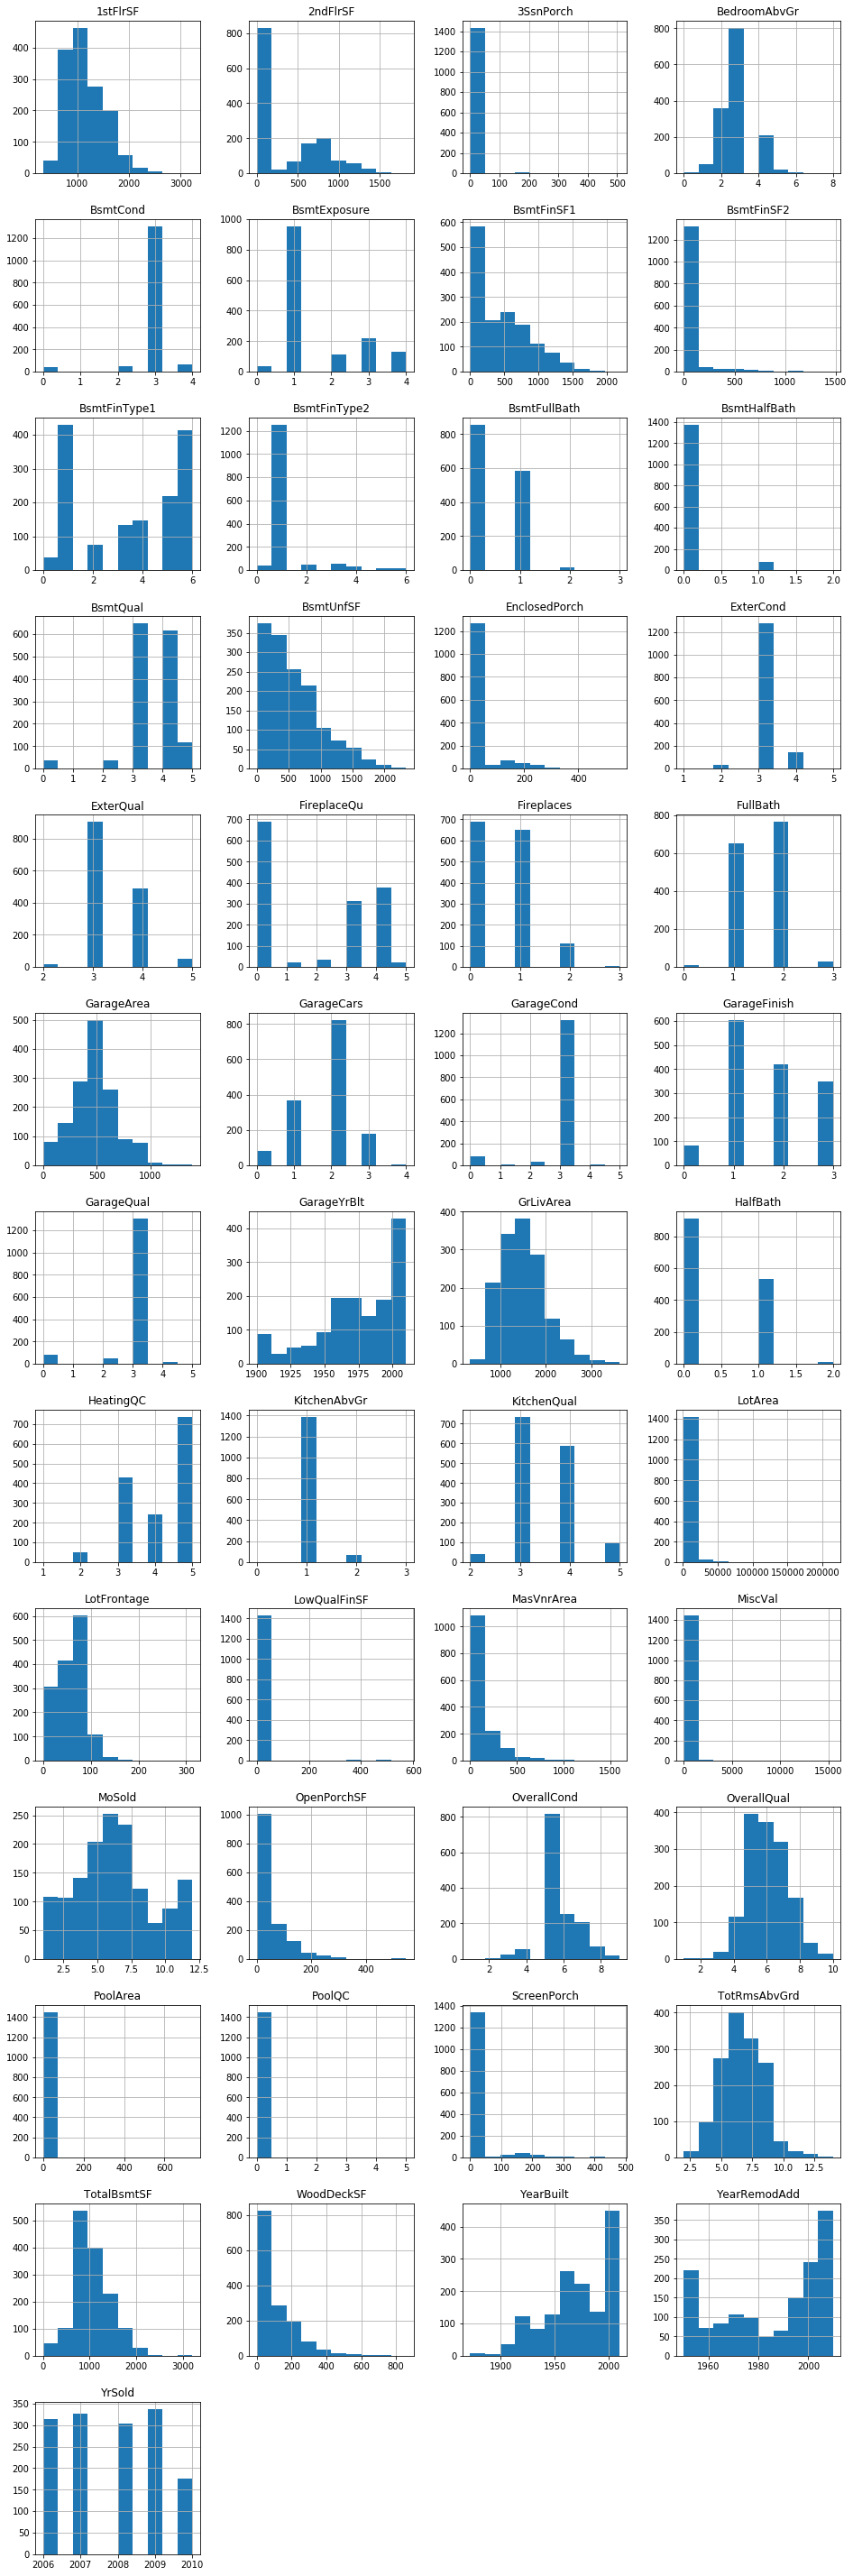

In [28]:
# Histograms for each attribute
x_original_df.hist(layout=(dispRow,dispCol))
pyplot.show()

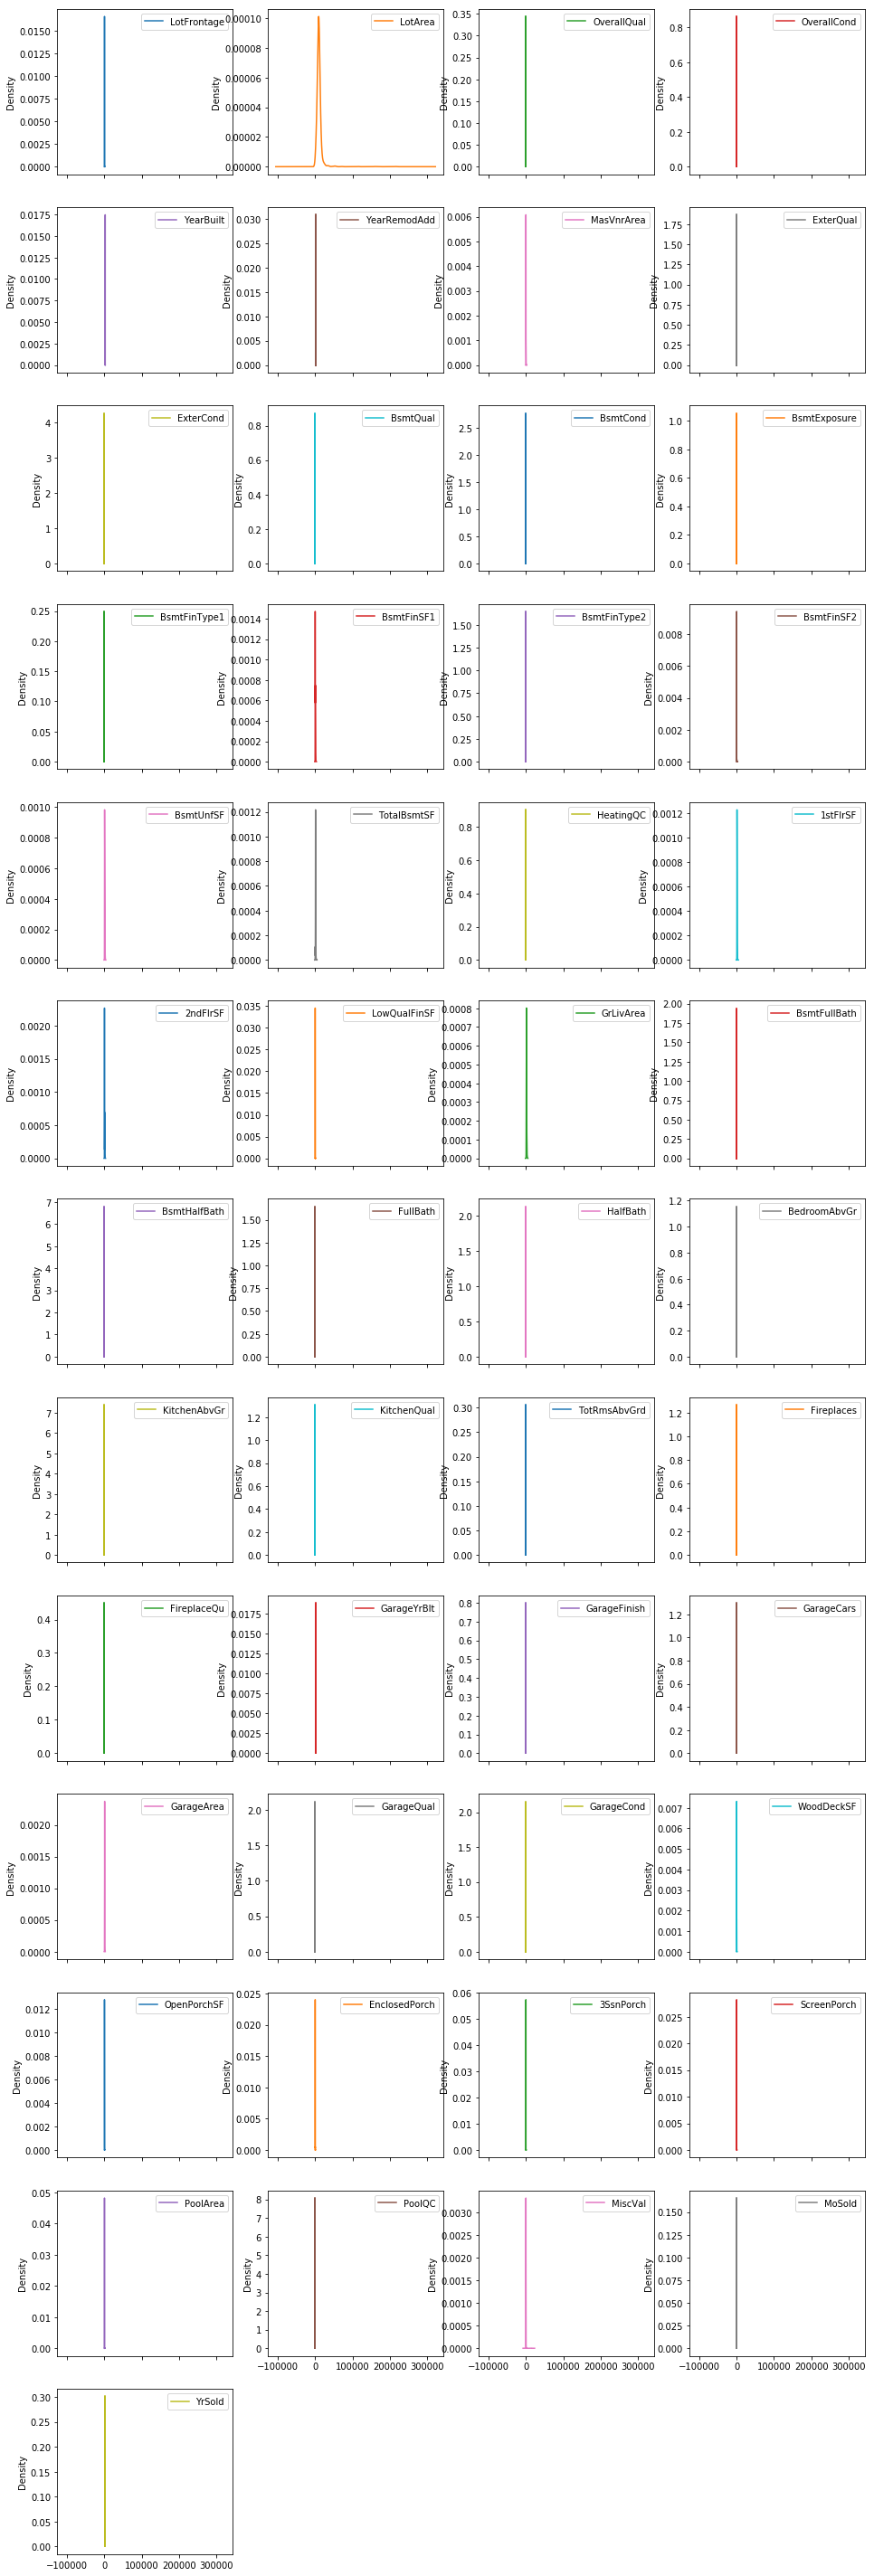

In [29]:
# Density plot for each attribute
x_original_df.plot(kind='density', subplots=True, layout=(dispRow,dispCol))
pyplot.show()

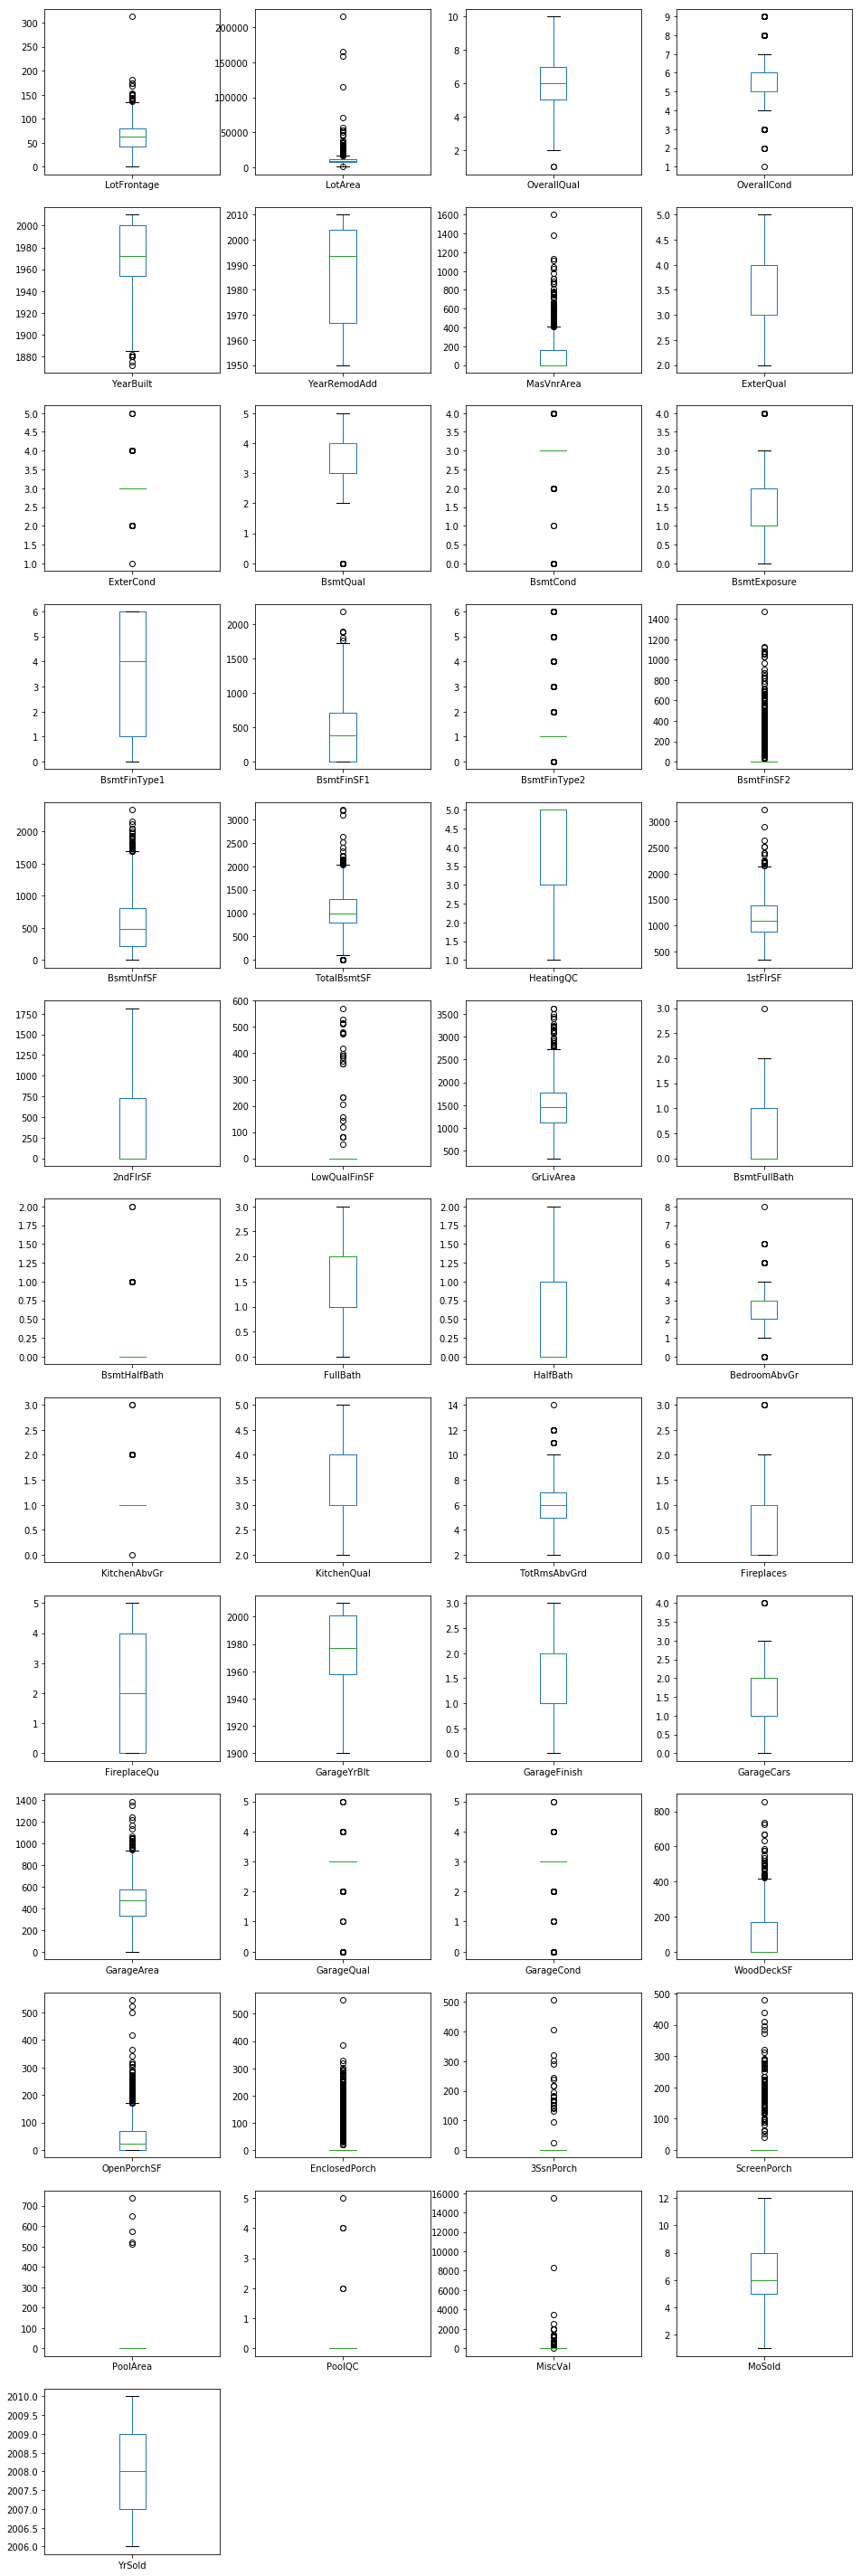

In [30]:
# Box and Whisker plot for each attribute
x_original_df.plot(kind='box', subplots=True, layout=(dispRow,dispCol))
pyplot.show()

#### 2.b.ii) Multivariate plots to better understand the relationships between attributes

In [31]:
# Scatterplot matrix
# scatter_matrix(x_original_df)
# pyplot.show()

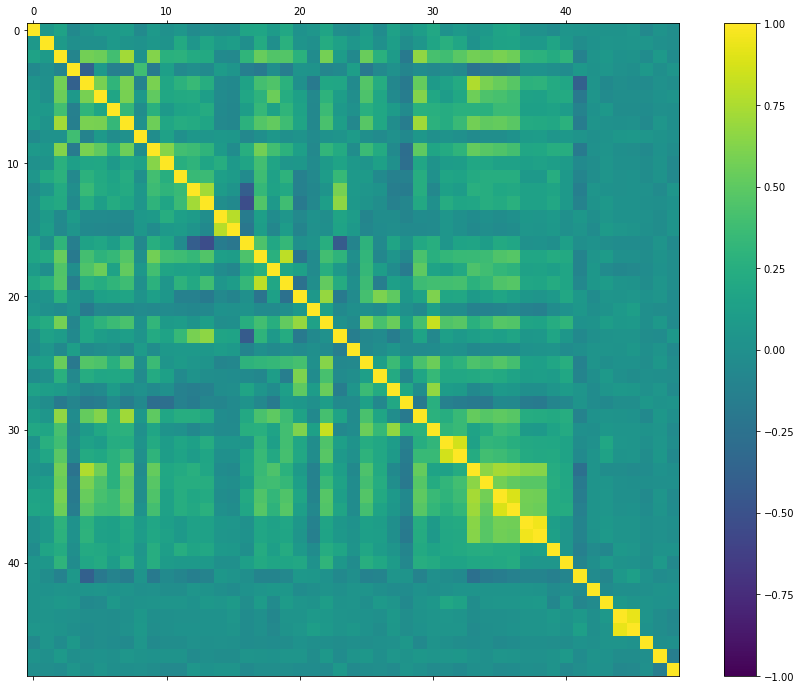

In [32]:
# Correlation matrix
fig = pyplot.figure(figsize=(16,12))
ax = fig.add_subplot(111)
correlations = x_original_df.corr(method='pearson')
cax = ax.matshow(correlations, vmin=-1, vmax=1)
fig.colorbar(cax)
pyplot.show()

In [33]:
if (notifyStatus): email_notify("Data Summarization and Visualization completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Section 3 - Prepare Data
Some dataset may require additional preparation activities that will best exposes the structure of the problem and the relationships between the input attributes and the output variable. Some data-prep tasks might include:

* Cleaning data by removing duplicates, marking missing values and even imputing missing values.
* Feature selection where redundant features may be removed.
* Data transforms where attributes are scaled or redistributed in order to best expose the structure of the problem later to learning algorithms.

In [34]:
if (notifyStatus): email_notify("Data Cleaning and Transformation has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 3.a) Feature Selection

In [35]:
# Not applicable for this iteration of the project

### 3.b) Data Transforms

In [36]:
# Apply the One-Hot-Encoding (dummy variable handling) technique
x_original_df = get_dummies(x_original_df)
print(x_original_df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1456 entries, 1 to 1460
Columns: 258 entries, LotFrontage to SaleCondition_Partial
dtypes: float64(3), int64(46), uint8(209)
memory usage: 865.9 KB
None


### 3.c) Splitting Data into Training and Testing Sets

In [37]:
# Use 70% of the data to train the models and the remaining for testing/validation
validation_size = 0.30
x_train_df, x_test_df, y_train_df, y_test_df = train_test_split(x_original_df, y_original_df, test_size=validation_size, random_state=seedNum)
print("xy_original_df.shape: {} x_original_df.shape: {}".format(xy_original_df.shape, x_original_df.shape))
print("x_train_df.shape: {} y_train_df.shape: {}".format(x_train_df.shape, y_train_df.shape))
print("x_test_df.shape: {} y_test_df.shape: {}".format(x_test_df.shape, y_test_df.shape))

xy_original_df.shape: (1456, 80) x_original_df.shape: (1456, 258)
x_train_df.shape: (1019, 258) y_train_df.shape: (1019,)
x_test_df.shape: (437, 258) y_test_df.shape: (437,)


### 3.d) Display the Final Datasets for Model-Building

In [38]:
# We finalize the training and testing datasets for the modeling activities
x_train = x_train_df.values
y_train = y_train_df.values
x_test = x_test_df.values
y_test = y_test_df.values
print("x_train.shape: {} y_train.shape: {}".format(x_train.shape, y_train.shape))
print("x_test.shape: {} y_test.shape: {}".format(x_test.shape, y_test.shape))

x_train.shape: (1019, 258) y_train.shape: (1019,)
x_test.shape: (437, 258) y_test.shape: (437,)


In [39]:
if (notifyStatus): email_notify("Data Cleaning and Transformation completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## 4. Model and Evaluate Algorithms
After the data-prep, we next work on finding a workable model by evaluating a subset of machine learning algorithms that are good at exploiting the structure of the training. The typical evaluation tasks include:

* Defining test options such as cross validation and the evaluation metric to use.
* Spot checking a suite of linear and nonlinear machine learning algorithms.
* Comparing the estimated accuracy of algorithms.

For this project, we will evaluate four linear, two non-linear, and four ensemble algorithms:

Linear Algorithms: Linear Regression, Ridge Regression, LASSO Regression, and Elastic Net Regression

Non-Linear Algorithms: Decision Trees (CART) and k-Nearest Neighbors

Ensemble Algorithms: Random Forest, Extra Trees, Stochastic Gradient Boosting, and eXtreme Gradient Boosting

The random number seed is reset before each run to ensure that the evaluation of each algorithm is performed using the same data splits. It ensures the results are directly comparable.

### 4.a) Set test options and evaluation metric

In [40]:
# Run algorithms using 10-fold cross validation
num_folds = 10
scoring = 'neg_mean_squared_error'

In [41]:
# Set up Algorithms Spot-Checking Array
models = []
# models.append(('LR', LinearRegression(n_jobs=cpu_num)))
models.append(('RR', Ridge(random_state=seedNum)))
models.append(('LASSO', Lasso(random_state=seedNum)))
models.append(('EN', ElasticNet(random_state=seedNum)))
models.append(('CART', DecisionTreeRegressor(random_state=seedNum)))
models.append(('KNN', KNeighborsRegressor(n_jobs=cpu_num)))
models.append(('RF', RandomForestRegressor(random_state=seedNum, n_jobs=cpu_num)))
models.append(('ET', ExtraTreesRegressor(random_state=seedNum, n_jobs=cpu_num)))
models.append(('GBM', GradientBoostingRegressor(random_state=seedNum)))
# models.append(('XGB', XGBRegressor(random_state=seedNum, n_jobs=cpu_num)))
results = []
names = []
metrics = []

In [42]:
# Generate model in turn
for name, model in models:
	if (notifyStatus): email_notify("Algorithm "+name+" modeling has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))
	startTimeModule = datetime.now()
	kfold = KFold(n_splits=num_folds, random_state=seedNum)
	cv_results = cross_val_score(model, x_train, y_train, cv=kfold, scoring=scoring)
	results.append(cv_results)
	names.append(name)
	metrics.append(cv_results.mean())
	msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
	print(msg)
	print ('Model training time:',(datetime.now() - startTimeModule))
	if (notifyStatus): email_notify("Algorithm "+name+" modeling completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))
print ('Average RMSE from all models:',int(math.sqrt(np.mean(metrics)*-1)))

RR: -664129517.402464 (199834902.149198)
Model training time: 0:00:00.055030


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of

LASSO: -695433154.735557 (170154523.451488)
Model training time: 0:00:02.496857


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of

EN: -742782150.739981 (211288409.126745)
Model training time: 0:00:03.084808
CART: -1483054833.706921 (289800161.462854)
Model training time: 0:00:00.406666
KNN: -1937527141.157656 (591962840.597084)
Model training time: 0:00:00.214394
RF: -855772894.132678 (261405709.776968)
Model training time: 0:00:02.262229
ET: -727451775.069648 (213490579.707023)
Model training time: 0:00:02.631213
GBM: -594483635.057205 (221688691.165161)
Model training time: 0:00:06.607603
Average RMSE from all models: 31025


### 4.b) Spot-checking baseline algorithms

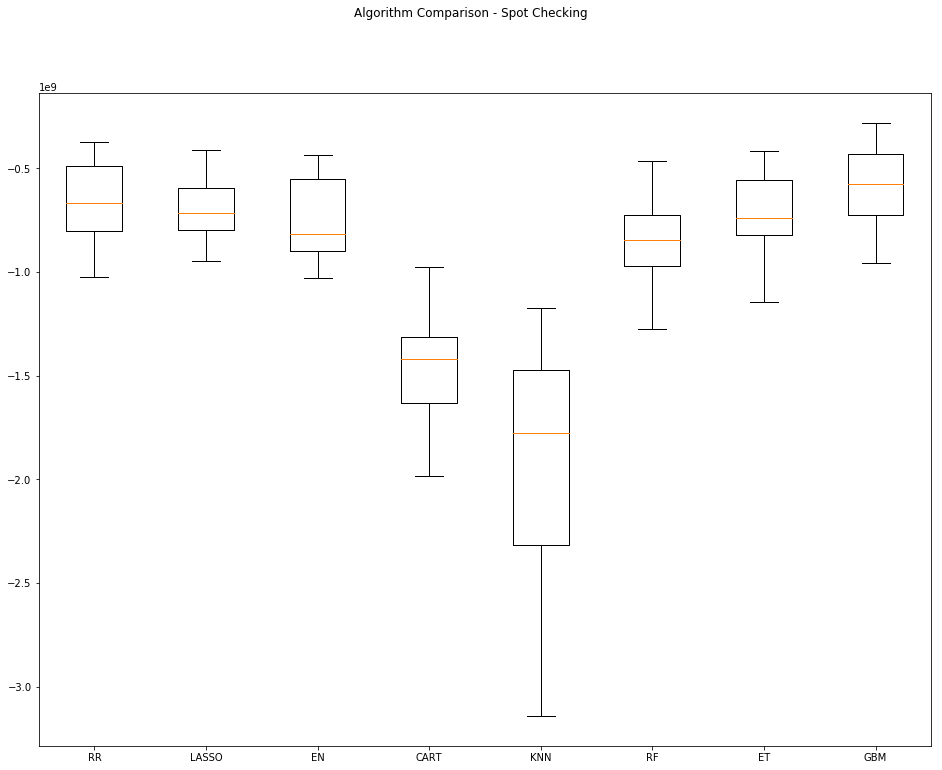

In [43]:
fig = pyplot.figure(figsize=(16,12))
fig.suptitle('Algorithm Comparison - Spot Checking')
ax = fig.add_subplot(111)
pyplot.boxplot(results)
ax.set_xticklabels(names)
pyplot.show()

## Section 5 - Improve Accuracy
After we achieve a short list of machine learning algorithms with good level of accuracy, we can leverage ways to improve the accuracy of the models.

### 5.a) Algorithm Tuning

In [44]:
# Set up the comparison array
results = []
names = []

In [45]:
# Tuning algorithm #1 - Ridge Regression
if (notifyStatus): email_notify("Algorithm #1 tuning has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))
startTimeModule = datetime.now()
paramGrid1 = dict(solver=['svd','cholesky','lsqr','sparse_cg','sag','saga'])
model1 = Ridge(random_state=seedNum)
kfold = KFold(n_splits=num_folds, random_state=seedNum)
grid1 = GridSearchCV(estimator=model1, param_grid=paramGrid1, scoring=scoring, cv=kfold)
grid_result1 = grid1.fit(x_train, y_train)

print("Best: %f using %s" % (grid_result1.best_score_, grid_result1.best_params_))
results.append(grid_result1.cv_results_['mean_test_score'])
names.append('RR')
means = grid_result1.cv_results_['mean_test_score']
stds = grid_result1.cv_results_['std_test_score']
params = grid_result1.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
print ('Best RMSE for the Model is:', int(math.sqrt((grid_result1.best_score_*-1))))
print ('Model training time:', (datetime.now() - startTimeModule))
if (notifyStatus): email_notify("Algorithm #1 tuning completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

Best: -664327242.461369 using {'solver': 'svd'}
-664327242.461369 (199833181.420927) with: {'solver': 'svd'}
-664327242.473968 (199833181.425690) with: {'solver': 'cholesky'}
-1128413474.855368 (306095538.914814) with: {'solver': 'lsqr'}
-1112744291.897086 (302906115.738627) with: {'solver': 'sparse_cg'}
-1401088858.158205 (377222075.942649) with: {'solver': 'sag'}
-1504443960.354745 (408506292.437750) with: {'solver': 'saga'}
Best RMSE for the Model is: 25774
Model training time: 0:00:32.157917


In [46]:
# Tuning algorithm #2 - Gradient Boosting
if (notifyStatus): email_notify("Algorithm #2 tuning has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))
startTimeModule = datetime.now()
paramGrid2 = dict(n_estimators=np.array([100,200,300,400,500]))
model2 = GradientBoostingRegressor(random_state=seedNum)
kfold = KFold(n_splits=num_folds, random_state=seedNum)
grid2 = GridSearchCV(estimator=model2, param_grid=paramGrid2, scoring=scoring, cv=kfold)
grid_result2 = grid2.fit(x_train, y_train)

print("Best: %f using %s" % (grid_result2.best_score_, grid_result2.best_params_))
results.append(grid_result2.cv_results_['mean_test_score'])
names.append('GBM')
means = grid_result2.cv_results_['mean_test_score']
stds = grid_result2.cv_results_['std_test_score']
params = grid_result2.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
print ('Best RMSE for the Model is:', int(math.sqrt((grid_result2.best_score_*-1))))
print ('Model training time:', (datetime.now() - startTimeModule))
if (notifyStatus): email_notify("Algorithm #2 tuning completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

Best: -557540249.536326 using {'n_estimators': 500}
-594669952.151399 (221717606.348136) with: {'n_estimators': 100}
-572694198.373398 (222266826.526097) with: {'n_estimators': 200}
-564288013.639844 (225134278.993734) with: {'n_estimators': 300}
-559146824.436751 (226080225.974113) with: {'n_estimators': 400}
-557540249.536326 (226455535.531617) with: {'n_estimators': 500}
Best RMSE for the Model is: 23612
Model training time: 0:01:35.099323


### 5.b) Compare Algorithms After Tuning

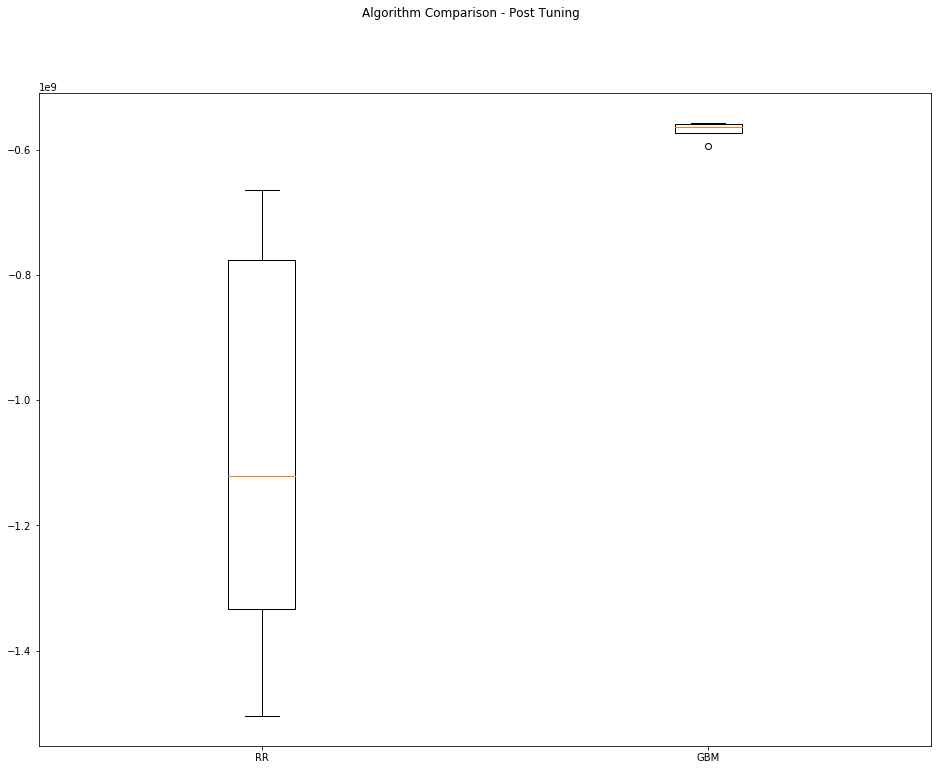

In [47]:
fig = pyplot.figure(figsize=(16,12))
fig.suptitle('Algorithm Comparison - Post Tuning')
ax = fig.add_subplot(111)
pyplot.boxplot(results)
ax.set_xticklabels(names)
pyplot.show()

## Section 6 - Finalize Model
Once we have narrow down to a model that we believe can make accurate predictions on unseen data, we are ready to finalize it. Finalizing a model may involve sub-tasks such as:
* Using an optimal model tuned to make predictions on unseen data.
* Creating a standalone model using the tuned parameters
* Saving an optimal model to file for later use.

In [48]:
if (notifyStatus): email_notify("Model Validation and Final Model Creation has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 6.a) Predictions on validation dataset

In [49]:
model = Ridge(solver='svd', random_state=seedNum)
model.fit(x_train, y_train)
predictions = model.predict(x_test)
print('RMSE for the model is: ', int(math.sqrt(mean_squared_error(y_test, predictions))))
print('R2 for the model is: ', r2_score(y_test, predictions))

RMSE for the model is:  26228
R2 for the model is:  0.8928333482734467


In [50]:
model = GradientBoostingRegressor(n_estimators=500, random_state=seedNum)
model.fit(x_train, y_train)
predictions = model.predict(x_test)
print('RMSE for the model is: ', int(math.sqrt(mean_squared_error(y_test, predictions))))
print('R2 for the model is: ', r2_score(y_test, predictions))

RMSE for the model is:  21130
R2 for the model is:  0.93044415128582


### 6.b) Create standalone model on entire training dataset

In [51]:
startTimeModule = datetime.now()

# Combining the training and testing datasets to form the complete dataset that will be used for training the final model
x_complete = np.vstack((x_train, x_test))
y_complete = np.concatenate((y_train, y_test))
print("x_complete.shape: {} y_complete.shape: {}".format(x_complete.shape, y_complete.shape))

finalModel = GradientBoostingRegressor(n_estimators=500, random_state=seedNum)
finalModel.fit(x_complete, y_complete)
print ('Model training time:',(datetime.now() - startTimeModule))

x_complete.shape: (1456, 258) y_complete.shape: (1456,)
Model training time: 0:00:03.443811


### 6.c) Save model for later use

In [52]:
# modelName = 'finalModel_BinaryClass.sav'
# dump(finalModel, modelName)

In [53]:
if (notifyStatus): email_notify("Model Validation and Final Model Creation completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

In [54]:
print ('Total time for the script:',(datetime.now() - startTimeScript))

Total time for the script: 0:03:03.539731
